In [3]:
#Import necessary packages
import numpy as np
import matplotlib.pyplot as plt
import xpress as xp
import math

In [4]:
#Test plot a rotated uncentered ellipse
def plot_ellipse (ax, a, b, x0, y0, theta):
    t = np.linspace(0,2*math.pi,100)
    x = x0 + a*np.cos(t)*np.cos(theta) - b*np.sin(t)*np.sin(theta)
    y = y0 + b*np.sin(t)*np.cos(theta) + a*np.cos(t)*np.sin(theta)
    ax.plot(x,y)

# a=5 #Major axis length
# b=1 #Minor axis length
# x0 = 0.5 #x-coord of center
# y0 = 0.9 #y-coord of center
# theta = 1
# fig = plt.figure()
# ax = fig.add_subplot(111, aspect='equal')
# plot_ellipse(ax, a, b, x0, y0, theta)

In [5]:
k0low_range = np.fromfile('246_k0low.dat', sep="\n")*1e5
k0high_range = np.fromfile('246_k0high.dat', sep="\n")*1e5

num_points = k0low_range.shape[0]
dmax_range = np.zeros((2,num_points))
dmax_range[0] = np.fromfile('246_dmax_low.dat', sep="\n")
dmax_range[1] = np.fromfile('246_dmax_high.dat', sep="\n")

In [6]:
#Create the xy pairs from dmax and k0s
xy_left = np.vstack((k0low_range, dmax_range[0])) #Left bounding points
xy_right = np.vstack((k0high_range, dmax_range[1])) #Right bounding points

#Add the top and bottom bounding points
num_boundpoints = xy_left.shape[1]
xy_top_xs = np.linspace(xy_left[0][0], xy_right[0][0], num_boundpoints)
xy_bottom_xs = np.linspace(xy_left[0][-1], xy_right[0][-1], num_boundpoints)
xy_top_ys = np.repeat(dmax_range[0][0], num_boundpoints)
xy_bottom_ys = np.repeat(dmax_range[0][-1], num_boundpoints)
xy_top = np.vstack((xy_top_xs, xy_top_ys)) #Top bounding points
xy_bottom = np.vstack((xy_bottom_xs, xy_bottom_ys)) #Bottom bounding points

In [7]:
#Define problem, pi, and variables
p = xp.problem()

pi = math.pi
t = np.linspace(0,2*pi,40)
num_parampoints = len(t)

a = xp.var(name="a", lb=1e-3, ub=50, vartype=xp.continuous) #Major axis
b = xp.var(name="b", lb=1e-3, ub=50, vartype=xp.continuous) #Minor axis
x0 = xp.var(name="x0", lb=1e-3, ub=50, vartype=xp.continuous) #Center point x
y0 = xp.var(name="y0", lb=1e-3, ub=50, vartype=xp.continuous) #Center point y
theta = xp.var(name="theta", lb=0, ub=pi/2, vartype=xp.continuous) #Rotation of ellipse
ind_r_a = xp.vars(num_parampoints, num_boundpoints, name="ind_r_a", vartype=xp.binary)
ind_r_b = xp.vars(num_parampoints, num_boundpoints, name="ind_r_b", vartype=xp.binary)
ind_l_a = xp.vars(num_parampoints, num_boundpoints, name="ind_l_a", vartype=xp.binary)
ind_l_b = xp.vars(num_parampoints, num_boundpoints, name="ind_l_b", vartype=xp.binary)
p.addVariable(a, b, x0, y0, theta, ind_r_a, ind_r_b, ind_l_a, ind_l_b)

In [8]:
# #Setup the optimization problem (via nonlinear x,y) 
# #Get the limits manually (using these variables in the expression doesn't work on FICO 8.11)
# # print (xy_right[0][-1])
# # print (xy_right[1][0])
# # print (xy_left[0][0])
# # print (xy_left[1][-1])

# # Define points defining the ellipse
# x = xp.vars (num_parampoints, name="x", lb=-xp.infinity, vartype=xp.continuous)
# y = xp.vars (num_parampoints, name="y", lb=-xp.infinity, vartype=xp.continuous)
# p.addVariable(x, y)

# for i in range(num_parampoints):
#     p.addConstraint (x[i] == x0 + a*xp.cos(t[i])*xp.cos(theta) - b*xp.sin(t[i])*xp.sin(theta))
#     p.addConstraint (y[i] == y0 + b*xp.sin(t[i])*xp.cos(theta) + a*xp.cos(t[i])*xp.sin(theta))

# #Define the bounding constraints
# for i in range(num_parampoints):
#     for j in range(num_boundpoints):
#         #Add constraint that emulates either x[i] <= xy_right[0][j] OR y[i] <= xy_right[1][j]
#         p.addConstraint (x[i] <= xy_right[0][j] + (1-ind_r_a[i][j]) * (7.56-xy_right[0][j]))
#         p.addConstraint (y[i] <= xy_right[1][j] + (1-ind_r_b[i][j]) * (24.96-xy_right[1][j]))
#         p.addConstraint (ind_r_a[i][j] + ind_r_b[i][j] >= 1)
        
#         #Add constraint that emulates either x[i] >= xy_left[0][j] OR y[i] >= xy_left[1][j]
#         p.addConstraint (x[i] >= xy_left[0][j] + (1-ind_l_a[i][j]) * (0.0957 - xy_left[0][j]))
#         p.addConstraint (y[i] >= xy_left[1][j] + (1-ind_l_b[i][j]) * (13.58 - xy_left[1][j]))
#         p.addConstraint (ind_l_a[i][j] + ind_l_b[i][j] >= 1)

#         #Add top and bottom bounding constraints
#         p.addConstraint (y[i] <= xy_top[1][j])
#         p.addConstraint (y[i] >= xy_bottom[1][j])

# area = pi*a*b

In [9]:
#Setup the optimization problem (via manual limits) 
#Get the limits manually (using these variables in the expression doesn't work on FICO 8.11)
# print (xy_right[0][-1])
# print (xy_right[1][0])
# print (xy_left[0][0])
# print (xy_left[1][-1])

# Define points defining the ellipse
x = [x0 + a*xp.cos(t[i])*xp.cos(theta) - b*xp.sin(t[i])*xp.sin(theta) for i in range(num_parampoints)] #x-coords of ellipse
y = [y0 + b*xp.sin(t[i])*xp.cos(theta) + a*xp.cos(t[i])*xp.sin(theta) for i in range(num_parampoints)] #y-coords of ellipse

#Define the bounding constraints
for i in range(num_parampoints):
    for j in range(num_boundpoints):
        #Add constraint that emulates either x[i] <= xy_right[0][j] OR y[i] <= xy_right[1][j]
        p.addConstraint (x[i] <= xy_right[0][j] + (1-ind_r_a[i][j]) * (23-xy_right[0][j]))
        p.addConstraint (y[i] <= xy_right[1][j] + (1-ind_r_b[i][j]) * (22.4-xy_right[1][j]))
        p.addConstraint (ind_r_a[i][j] + ind_r_b[i][j] >= 1)
        
        #Add constraint that emulates either x[i] >= xy_left[0][j] OR y[i] >= xy_left[1][j]
        p.addConstraint (x[i] >= xy_left[0][j] + (1-ind_l_a[i][j]) * (0.1 - xy_left[0][j]))
        p.addConstraint (y[i] >= xy_left[1][j] + (1-ind_l_b[i][j]) * (4.12 - xy_left[1][j]))
        p.addConstraint (ind_l_a[i][j] + ind_l_b[i][j] >= 1)

        #Add top and bottom bounding constraints
        p.addConstraint (y[i] <= xy_top[1][j])
        p.addConstraint (y[i] >= xy_bottom[1][j])

area = pi*a*b

In [10]:
#Run the maximization
p.setObjective(area - y0*2, xp.maximize)
p.controls.xslp_heurstrategy = 1
p.controls.xslp_maxtime = -2000
p.solve()

Problem classification: general with process flow structure (300)
Original problem size
   linear:    8000 rows, 4006 columns, 14000 linear coefficients
   quadratic: 2 in obj, 0 rows, 0 in rows
   nonlinear: 6150 coefficients, 91350 tokens
Nonlinear presolve
   converted quadratic objective into an SLP constraint
   objective transfer row R8001 through variable C4007
   bound tightening reduced 24 bounds
   objective transfer row R8001 through variable C4007
Presolved problem size
   linear:    8001 rows, 4007 columns, 14001 linear coefficients
   nonlinear: 6151 coefficients, 91355 tokens
Problem is nonlinear presolved
FICO Xpress v8.11.0, Hyper, solve started 9:17:00, Jan 23, 2021
Control settings used:
XSLP_MAXTIME = -2000
XSLP_POSTSOLVE = 1
XSLP_HEURSTRATEGY = 1
XSLP_DELETIONCONTROL = 0
XSLP_OBJSENSE = -1
OUTPUTLOG = 1

Maximum expanded nl-formula size: 17  (row 'R201')
Total tokens: 2355
  8  parallel calculation threads
  Jacobian: symbolic differentiation
          81 base AD f

In [11]:
area = p.getSolution(area)
a = p.getSolution(a)
b = p.getSolution(b)
x0 = p.getSolution(x0)
y0 = p.getSolution(y0)
theta = p.getSolution(theta)

print (list((area, a, b, x0, y0, theta)))

[57.95375587532219, 1.9968350044482757, 9.23824622239831, 2.5192748101438527, 13.272578646458001, 0.14130963688941978]


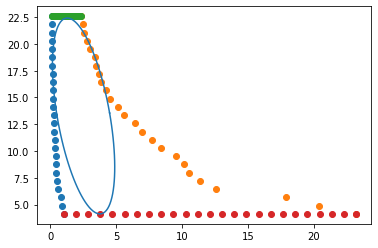

In [12]:
def plot_xypoints(ax, xy):
    ax.scatter(xy[0], xy[1])

fig = plt.figure()
ax = fig.add_subplot(111)
plot_xypoints(ax, xy_left)
plot_xypoints(ax, xy_right)
plot_xypoints(ax, xy_top)
plot_xypoints(ax, xy_bottom)
plot_ellipse (ax, a, b, x0, y0, theta)

In [13]:
#Save the ellipse definition
import json
ellipse = {"a":a, "b":b, "x0":x0, "y0":y0, "theta":theta}
with open('246ellipse_def_ver.json', 'w', encoding='utf-8') as f:
    json.dump(ellipse, f, ensure_ascii=False, indent=4)